In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import matplotlib 
import datetime as td
matplotlib.rc_file_defaults()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
params = {'xtick.labelsize': 10, 'ytick.labelsize': 10}
matplotlib.rcParams.update(params)
pd.set_option('display.max_columns', None)

In [2]:
# Cargamos los datos
file_stats = "SQMStats_Pangamos_20210830-20220203v3.xlsx"
df = pd.read_excel(file_stats)
df_mop = df[(df["Producto"].notna()) & (df["Producto"].str.contains("MOP")) 
            & df["Hora Ingreso a Puerto"].notna() & df["Hora Legada a Espera"].notna()]
df_mop.shape

(3218, 32)

In [3]:
# Dejamos columnas importantes
cols = df_mop.columns
cols = cols[~cols.str.contains("Unnamed")]
cols

Index(['Flota', 'Patente', 'Tipo', 'N Guia', 'Fecha', 'Producto', 'Viaje',
       'Origen', 'Origen inicio', 'Origen salida', 'Destino',
       'Destino termino', 'Hora Legada a Espera', 'Tiempo Espera [minutos]',
       'Hora Ingreso a Puerto', 'Tiempo Total en Puerto',
       'Tiempo total Descarga', 'Nombre Cancha', 'Nombre Geo Espera Exterior'],
      dtype='object')

In [4]:
cols = ['Hora Legada a Espera', 'Tiempo Espera [minutos]',
       'Hora Ingreso a Puerto', 'Tiempo Total en Puerto']

In [5]:
df_mop = df_mop[cols]

In [6]:
df_mop.head(1)

,Hora Legada a Espera,Tiempo Espera [minutos],Hora Ingreso a Puerto,Tiempo Total en Puerto
0,20210830 19:44:12,752.233333,20210831 08:29:21,98.133333


In [7]:
# Transformamos fechas en formato datetime
df_mop["Hora Ingreso a Puerto"] = pd.to_datetime(df_mop["Hora Ingreso a Puerto"])
df_mop["Hora Legada a Espera"] = pd.to_datetime(df_mop["Hora Legada a Espera"])

In [8]:
df_mop.head(1)

,Hora Legada a Espera,Tiempo Espera [minutos],Hora Ingreso a Puerto,Tiempo Total en Puerto
0,2021-08-30 19:44:12,752.233333,2021-08-31 08:29:21,98.133333


In [9]:
def Minutos_Sobrantes(t):
    if t.time() < td.time(8,30,0):
        t_aux = td.datetime(t.year, t.month, t.day, 8, 30, 0)
        dt = (t_aux - t).total_seconds()/60.
        return dt
    elif t.time() < td.time(14,0,0):
        return 0.
    elif t.time() < td.time(15,30,0):
        t_aux = td.datetime(t.year, t.month, t.day, 15, 30, 0)
        dt = (t_aux - t).total_seconds()/60.
        return dt
    elif t.time() < td.time(22,30,0):
        return 0.
    else:
        t_aux = td.datetime(t.year, t.month, t.day, 8, 30, 0) + td.timedelta(days=1)
        dt = (t_aux - t).total_seconds()/60.
        return dt

In [10]:
df_mop["Minutos Sobrantes"] = df_mop["Hora Legada a Espera"].apply(lambda x: Minutos_Sobrantes(x))

In [11]:
df_mop["Tiempo Espera Limpio"] = df_mop["Tiempo Espera [minutos]"] - df_mop["Minutos Sobrantes"]

In [133]:
df_clean = df_mop[df_mop["Tiempo Espera Limpio"]>0]
#df_mop["Tiempo Espera Limpio"] = df_mop.apply(lambda x: x["Tiempo Espera [minutos]"] - x["Minutos Sobrantes"] if (x["Tiempo Espera [minutos]"] - x["Minutos Sobrantes"]) > 0 else x["Tiempo Espera [minutos]"], axis = 1)
df_mop[df_mop["Tiempo Espera Limpio"]<0].head(3)

,Hora Legada a Espera,Tiempo Espera [minutos],Hora Ingreso a Puerto,Tiempo Total en Puerto,Minutos Sobrantes,Tiempo Espera Limpio
98,2021-08-31 14:28:38,4.016667,2021-08-31 15:10:25,105.783333,61.366667,-57.350000
142,2021-08-31 22:42:12,49.716667,2021-08-31 23:38:56,643.316667,587.800000,-538.083333
144,2021-08-31 22:43:11,49.450000,2021-08-31 23:42:37,641.116667,586.816667,-537.366667


In [13]:
df_clean["Tiempo de Espera Total"] = df_clean["Tiempo Espera Limpio"] + df_clean["Tiempo Total en Puerto"]

<ipython-input-13-9566a6e846d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Tiempo de Espera Total"] = df_clean["Tiempo Espera Limpio"] + df_clean["Tiempo Total en Puerto"]


In [14]:
camiones_totales = df_clean.shape[0]
camiones_sobre_75 = df_clean[df_clean["Tiempo de Espera Total"]>75].shape[0]

In [15]:
camiones_sobre_75, camiones_totales, camiones_totales-camiones_sobre_75

(1578, 2886, 1308)

In [16]:
percent = 100.*camiones_sobre_75/camiones_totales
percent, 100 - percent

(54.67775467775468, 45.32224532224532)

In [17]:
df_clean["Minutos Sobre 75 min"] = df_clean["Tiempo de Espera Total"].apply(lambda x: x-75 if x-75>0 else 0)

<ipython-input-17-a8f019baef1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Minutos Sobre 75 min"] = df_clean["Tiempo de Espera Total"].apply(lambda x: x-75 if x-75>0 else 0)


In [18]:
horas_exceso = df_clean["Minutos Sobre 75 min"].sum()/60.

In [19]:
horas_exceso

2725.874722222199

In [20]:
df_clean.head(1)

,Hora Legada a Espera,Tiempo Espera [minutos],Hora Ingreso a Puerto,Tiempo Total en Puerto,Minutos Sobrantes,Tiempo Espera Limpio,Tiempo de Espera Total,Minutos Sobre 75 min
0,2021-08-30 19:44:12,752.233333,2021-08-31 08:29:21,98.133333,0.0,752.233333,850.366667,775.366667


In [21]:
T_total = df_clean["Tiempo de Espera Total"]

In [22]:
T_total.max()

934.7166666669999

In [23]:
Bins = [15*i for i in range(16)]
Bins.append(480)
Bins.append(945)
h, b = np.histogram(T_total, bins=Bins)

In [24]:
bins = []
for i in range(len(b[:-1])):
    bins.append(str(round(b[i]))+"-"+str(round(b[i+1])))
bins = np.array(bins)

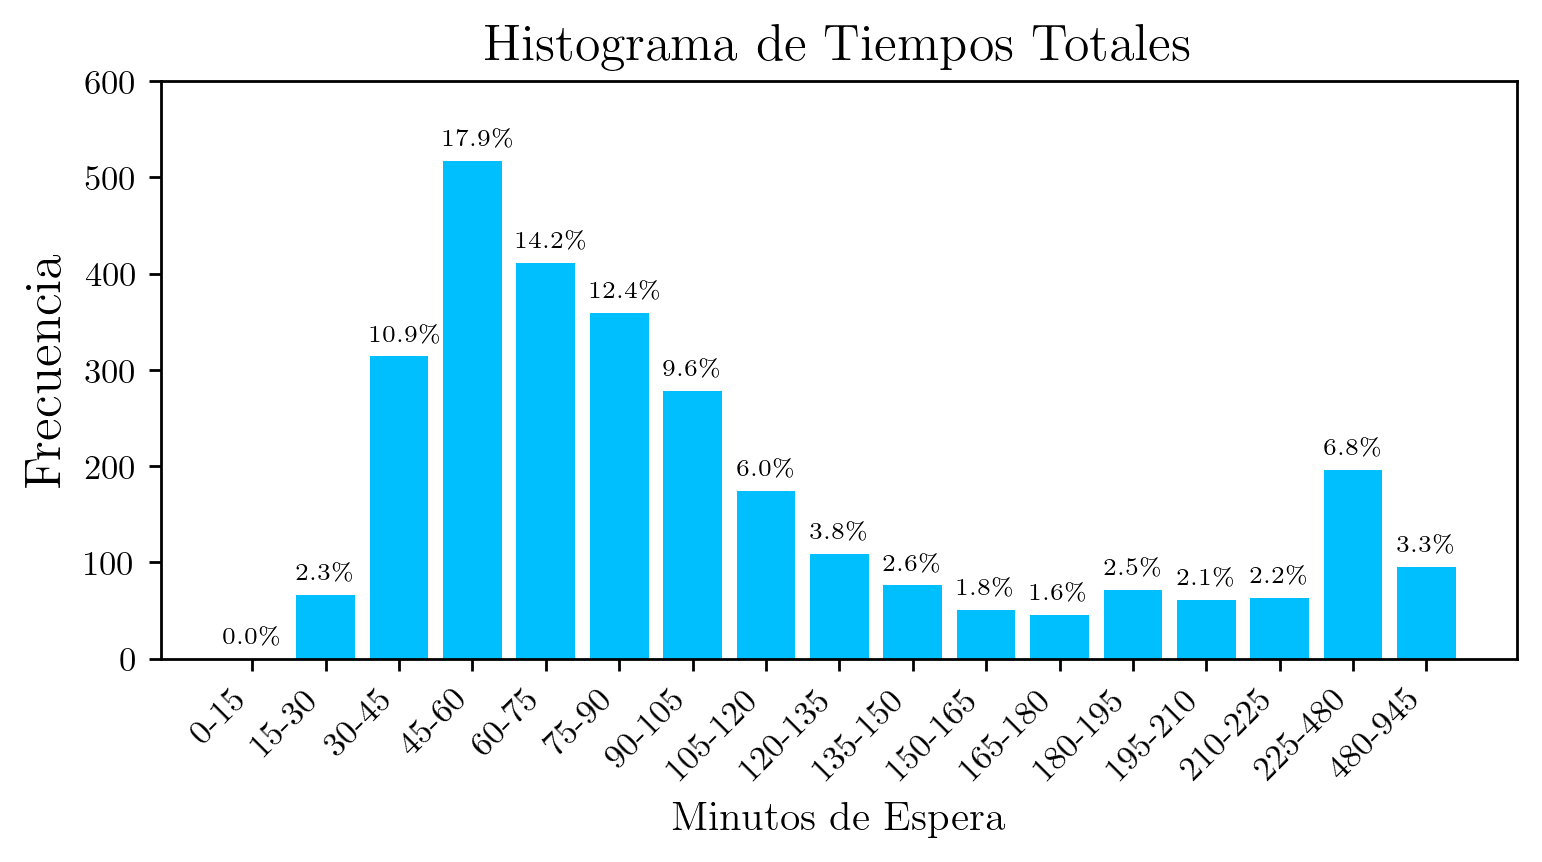

In [25]:
fig = plt.figure(figsize=(7,3), dpi = 250)

ax2 = fig.add_subplot(111)


ax2.bar(bins, h, label = "Tiempo Prom.", color = "deepskyblue" )
ax2.set_title("Histograma de Tiempos Totales", fontsize = 15)
ax2.set_ylabel("Frecuencia", fontsize = 15)

ax2.set_xticks(bins)
ax2.set_xticklabels(bins, rotation = 45, fontdict = {"horizontalalignment": "right"}) #xtick, fontsize=10,
ax2.set_xlabel("Minutos de Espera", fontsize = 12)
ax2.set_ylim([0,600])
#ax2.legend()
#ax2.axhline(y = T_semana.mean(), c = "r", 
                #linestyle = "--", linewidth = 1, label = "Tiempo Promedio \n Semanal")

perc = 100*h/h.sum()
for i, label in enumerate(perc):
    #if label > 0.1:
        plt.annotate(str(round(label,1)) + "\%", (i-0.4, h[i]+15.5), fontsize = 7)

plt.savefig("Graficos/Histograma de Tiempo Total.png", bbox_inches= "tight")

In [31]:
df_clean[df_clean["Tiempo de Espera Total"]>75].shape

(1578, 8)

In [72]:
df_nan = df[(df["Producto"].notna()) & (df["Producto"].str.contains("MOP")) 
            & (df["Hora Ingreso a Puerto"].notna()) & (~df["Hora Legada a Espera"].notna())]

In [73]:
df_nan.columns

Index(['Flota', 'Patente', 'Tipo', 'N Guia', 'Fecha', 'Producto', 'Viaje',
       'Origen', 'Origen inicio', 'Origen salida', 'Destino',
       'Destino termino', 'Hora Legada a Espera', 'Tiempo Espera [minutos]',
       'Hora Ingreso a Puerto', 'Tiempo Total en Puerto',
       'Tiempo total Descarga', 'Nombre Cancha', 'Nombre Geo Espera Exterior',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
       'Unnamed: 31'],
      dtype='object')

In [77]:
cols = ['Hora Legada a Espera', 'Tiempo Espera [minutos]',
       'Hora Ingreso a Puerto', 'Tiempo Total en Puerto']
df_nan = df_nan[cols]
df_nan.head(1)

,Hora Legada a Espera,Tiempo Espera [minutos],Hora Ingreso a Puerto,Tiempo Total en Puerto
150,NaN,0.0,20210901 08:18:23,148.116667


In [78]:
df_nan["Hora Ingreso a Puerto"] = pd.to_datetime(df_nan["Hora Ingreso a Puerto"])

In [85]:
df_nan["Minutos Sobre 75 min"] = df_nan["Tiempo Total en Puerto"].apply(lambda x: x-75 if x-75>0 else 0)

In [91]:
df_nan[df_nan["Tiempo Total en Puerto"]>60].shape

(78, 5)

In [88]:
df_nan["Minutos Sobre 75 min"].sum()/60.

7.385277777788334

In [92]:
total_nan = df_nan.shape[0]

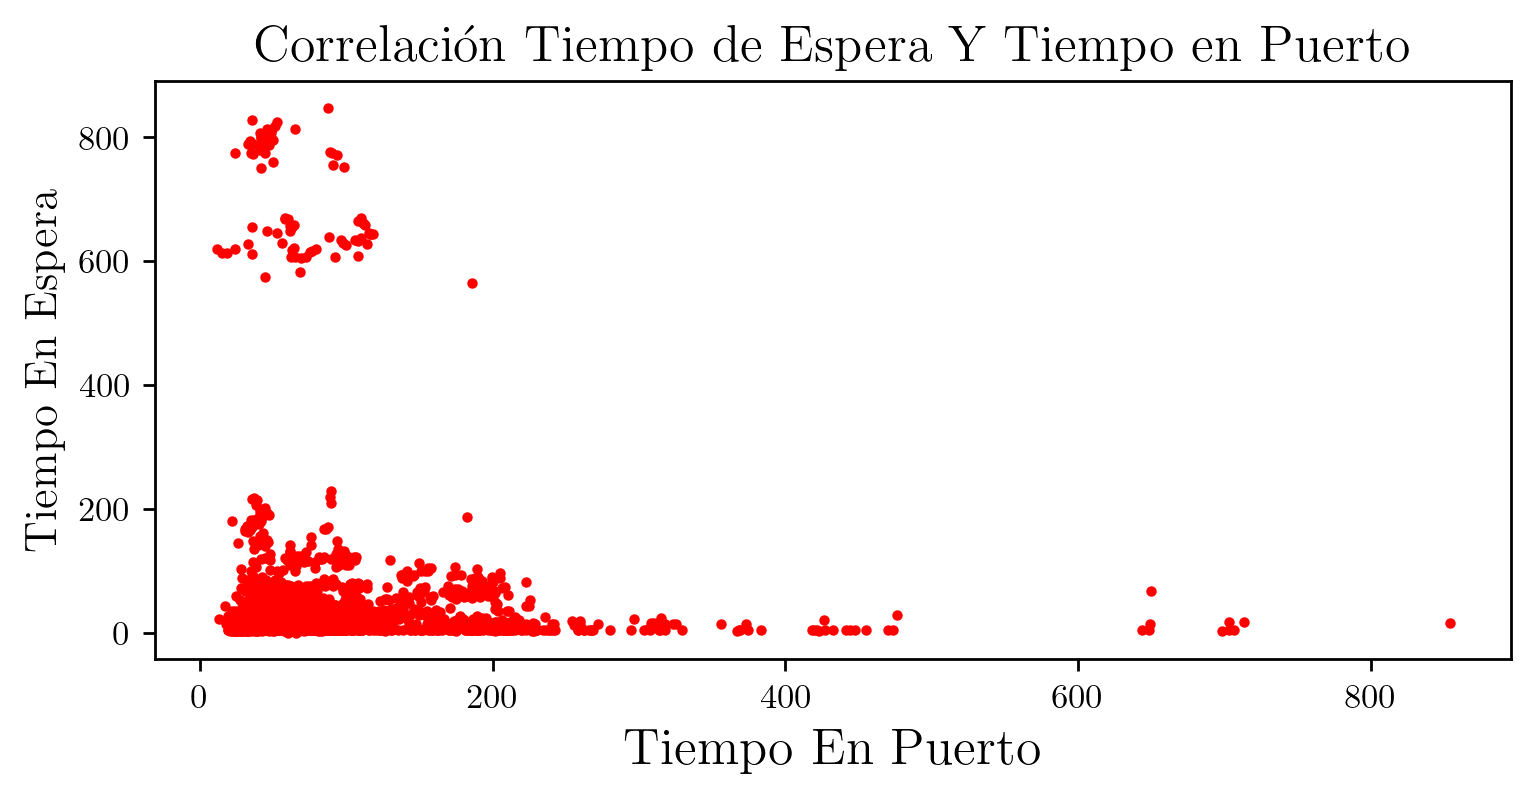

In [115]:
fig = plt.figure(figsize=(7,3), dpi = 250)

ax1 = fig.add_subplot(111)

ax1.set_title("Correlación Tiempo de Espera Y Tiempo en Puerto", fontsize = 15)
ax1.plot(df_clean["Tiempo Total en Puerto"], df_clean["Tiempo Espera Limpio"], "ro", markersize = 2)
ax1.set_xlabel("Tiempo En Puerto", fontsize = 15)
ax1.set_ylabel("Tiempo En Espera", fontsize = 13)

plt.show()

In [97]:
df_clean["Hora Entrada a Puerto"] = df_clean["Hora Ingreso a Puerto"].apply(lambda x: x.hour)

<ipython-input-97-14ef734a57fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Hora Entrada a Puerto"] = df_clean["Hora Ingreso a Puerto"].apply(lambda x: x.hour)


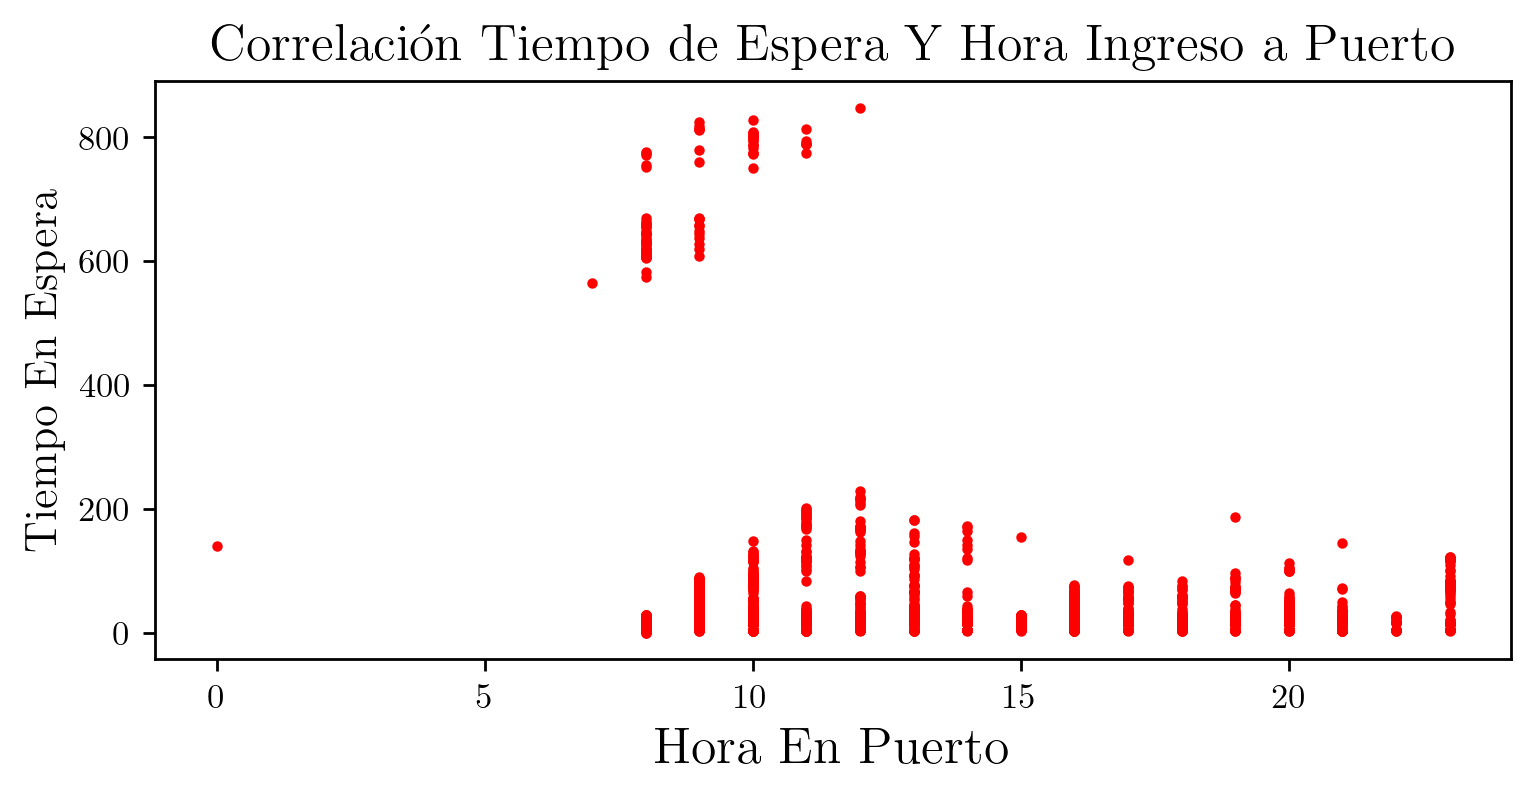

In [102]:
fig = plt.figure(figsize=(7,3), dpi = 250)

ax1 = fig.add_subplot(111)

ax1.set_title("Correlación Tiempo de Espera Y Hora Ingreso a Puerto", fontsize = 15)
ax1.plot(df_clean["Hora Entrada a Puerto"], df_clean["Tiempo Espera Limpio"],  "ro", markersize = 2)
ax1.set_xlabel("Hora En Puerto", fontsize = 15)
ax1.set_ylabel("Tiempo En Espera", fontsize = 13)

plt.show()

In [103]:
T_e = []
for i in range(24):
    T_e.append(df_clean["Tiempo Espera Limpio"][df_clean["Hora Entrada a Puerto"] == i].mean())

In [107]:
T_e = np.nan_to_num(T_e)
T_e

array([139.68333333,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 565.25      ,
       250.95181818,  71.75656304,  89.82673913,  60.67336601,
        41.84641148,  30.32736318,  32.3521097 ,  20.51119048,
        24.21449275,  19.82850242,  17.28256014,  18.93990148,
        21.69338006,  16.52709321,  13.66060606,  49.70245098])

In [108]:
def Prediccion_Espera(h):
    return T_e[h]

In [109]:
df_nan["Tiempo Espera Estimado"] = df_nan["Hora Ingreso a Puerto"].apply(lambda x: Prediccion_Espera(int(x.hour)))

In [111]:
df_nan["Tiempo Total Estimado"] = df_nan["Tiempo Total en Puerto"] + df_nan["Tiempo Espera Estimado"]

In [112]:
df_nan["Minutos Sobre 75 min"] = df_nan["Tiempo Total Estimado"].apply(lambda x: x-75 if x-75>0 else 0.)

In [123]:
horas_nan = df_nan["Minutos Sobre 75 min"].sum()/60.

In [125]:
horas_nan + horas_exceso

2969.874234094791

In [126]:
camiones_nan = df_nan.shape[0]

In [127]:
camiones_nan_75 = df_nan[df_nan["Tiempo Total Estimado"]>75].shape[0]

In [128]:
camiones_sobre_75 + camiones_nan_75

1653

In [129]:
camiones_totales + camiones_nan

2964

In [134]:
2964 - 1653

1311

In [130]:
100*(camiones_sobre_75 + camiones_nan_75)/(camiones_totales + camiones_nan)

55.76923076923077

In [131]:
100-55.76923076923077

44.23076923076923